# Imigração do Brasil para o Canadá — Análise *refeita* (1980+)
**Objetivo.** Explorar a evolução da imigração do **Brasil → Canadá** usando um dataset anual desde 1980, 
gerar métricas (YoY, participação, acumulado, índice base 100) e visualizar os padrões.

**Destaques do notebook**
- Pipeline robusto de leitura (tentativa de múltiplos encodings).
- Detecção automática da coluna de país e anos.
- Série do Brasil + comparação com países selecionados.
- Gráficos salvos como arquivos **PNG** e **embutidos** no notebook.
- Código organizado em funções, reprodutível.


In [1]:
%matplotlib inline

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pathlib import Path
print("Versões -> pandas:", pd.__version__)


Versões -> pandas: 1.5.3


In [3]:

# === Configuração ===
DATA_CANDIDATES = [
    Path("imigrantes_canada.csv"),
    Path("./data/imigrantes_canada.csv"),
    Path("/mnt/data/imigrantes_canada.csv"),
]
PAIS_ALVO = "Brazil"   # aceita 'Brazil' ou 'Brasil'
EXPORT_DIR = Path("./exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Países para comparação (ajuste à vontade)
PAISES_COMPARACAO = ["Brazil", "Argentina", "China", "India"]


In [4]:

def carregar_dados(candidates):
    path = None
    for p in candidates:
        if Path(p).exists():
            path = str(p)
            break
    if path is None:
        raise FileNotFoundError("Coloque 'imigrantes_canada.csv' na pasta do notebook ou ajuste DATA_CANDIDATES.")
    
    encodings_to_try = [None, "utf-8", "latin1", "cp1252"]
    last_err = None
    df = None
    for enc in encodings_to_try:
        try:
            if enc is None:
                df = pd.read_csv(path)
            else:
                df = pd.read_csv(path, encoding=enc)
            break
        except Exception as e:
            last_err = e
            continue
    if df is None:
        raise last_err
    return df, path

def detectar_colunas(df):
    country_candidates = ["country", "país", "pais", "odname", "country_name", "country of birth", "country.of.birth"]
    country_col = None
    for cand in country_candidates:
        for c in df.columns:
            if str(c).lower() == cand:
                country_col = c
                break
        if country_col:
            break
    if country_col is None:
        non_numeric_cols = [c for c in df.columns if not str(c).isdigit()]
        non_numeric_cols = [c for c in non_numeric_cols if str(c).lower() not in ["total"]]
        country_col = non_numeric_cols[0] if non_numeric_cols else df.columns[0]

    year_cols = [c for c in df.columns if str(c).isdigit() and 1900 <= int(str(c)) <= 2100]
    year_cols = sorted(year_cols, key=lambda x: int(x))
    years = [int(y) for y in year_cols]
    return country_col, year_cols, years


In [5]:

def obter_serie(df, country_col, year_cols, pais):
    countries_norm = df[country_col].astype(str).str.strip().str.lower()
    alvo_norm = pais.strip().lower()
    mask = countries_norm.isin([alvo_norm, "brazil" if alvo_norm=="brasil" else "brasil"])
    sub = df.loc[mask]
    if sub.empty:
        mask = countries_norm.str.contains(alvo_norm, na=False)
        sub = df.loc[mask]
    if sub.empty:
        raise ValueError(f"País '{pais}' não encontrado na coluna '{country_col}'.")

    series = sub[year_cols].sum(axis=0)
    series.index = [int(x) for x in series.index]
    return series

def montar_tabela_brasil(df, country_col, year_cols):
    br = obter_serie(df, country_col, year_cols, "Brazil")
    total = df[year_cols].sum(axis=0)
    total.index = [int(x) for x in total.index]

    out = pd.DataFrame({"Ano": br.index, "Imigrantes": br.values.astype(int)}).sort_values("Ano").reset_index(drop=True)
    out["Participacao_%"] = (out["Imigrantes"].values / total.loc[out["Ano"]].values) * 100.0
    out["YoY_Abs"] = out["Imigrantes"].diff()
    out["YoY_%"] = out["Imigrantes"].pct_change() * 100.0
    out["MM5"] = out["Imigrantes"].rolling(5, min_periods=1).mean()
    base = out.loc[out["Imigrantes"].ne(0), "Imigrantes"].iloc[0] if (out["Imigrantes"] != 0).any() else 1.0
    out["Indice_1980=100"] = (out["Imigrantes"] / base) * 100.0
    out["Acumulado"] = out["Imigrantes"].cumsum()
    return out, total


In [6]:

def plot_brasil_series(brazil_df, export_dir):
    plt.figure()
    plt.plot(brazil_df["Ano"], brazil_df["Imigrantes"], label="Imigrantes (ano)")
    plt.plot(brazil_df["Ano"], brazil_df["MM5"], label="Média móvel (5 anos)")
    plt.title("Brasil → Canadá: Imigrantes por ano")
    plt.xlabel("Ano"); plt.ylabel("Nº de imigrantes"); plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
    p1 = export_dir / "01_brasil_imigrantes_por_ano.png"
    plt.savefig(p1, bbox_inches="tight"); plt.show()

    plt.figure()
    plt.plot(brazil_df["Ano"], brazil_df["YoY_Abs"])
    plt.title("Brasil → Canadá: Variação absoluta ano a ano")
    plt.xlabel("Ano"); plt.ylabel("Δ imigrantes"); plt.grid(True, linestyle="--", alpha=0.5)
    p2 = export_dir / "02_brasil_yoy_abs.png"
    plt.savefig(p2, bbox_inches="tight"); plt.show()

    plt.figure()
    plt.plot(brazil_df["Ano"], brazil_df["Participacao_%"])
    plt.title("Participação do Brasil no total de imigrantes para o Canadá (%)")
    plt.xlabel("Ano"); plt.ylabel("Participação (%)"); plt.grid(True, linestyle="--", alpha=0.5)
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    p3 = export_dir / "03_brasil_participacao.png"
    plt.savefig(p3, bbox_inches="tight"); plt.show()

    plt.figure()
    plt.plot(brazil_df["Ano"], brazil_df["Acumulado"])
    plt.title("Brasil → Canadá: Acumulado desde 1980")
    plt.xlabel("Ano"); plt.ylabel("Total acumulado"); plt.grid(True, linestyle="--", alpha=0.5)
    p4 = export_dir / "04_brasil_acumulado.png"
    plt.savefig(p4, bbox_inches="tight"); plt.show()

    plt.figure()
    plt.plot(brazil_df["Ano"], brazil_df["Indice_1980=100"])
    plt.title("Brasil → Canadá: Índice (base no primeiro valor ≈ 100)")
    plt.xlabel("Ano"); plt.ylabel("Índice"); plt.grid(True, linestyle="--", alpha=0.5)
    p5 = export_dir / "05_brasil_indice_base100.png"
    plt.savefig(p5, bbox_inches="tight"); plt.show()

    return [p1, p2, p3, p4, p5]

def plot_comparacao(df, country_col, year_cols, paises, export_dir):
    plt.figure()
    for p in paises:
        try:
            s = obter_serie(df, country_col, year_cols, p)
            plt.plot(s.index, s.values, label=p)
        except Exception:
            pass
    plt.title("Comparação: países selecionados → Canadá (imigrantes por ano)")
    plt.xlabel("Ano"); plt.ylabel("Nº de imigrantes"); plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
    p = export_dir / "06_comparacao_paises.png"
    plt.savefig(p, bbox_inches="tight"); plt.show()
    return p

def plot_topN_ano(df, country_col, year_cols, ano, N, export_dir):
    col = str(ano)
    if col not in year_cols:
        raise ValueError(f"Ano {ano} não encontrado no dataset.")
    tmp = df[[country_col, col]].copy()
    tmp.columns = ["Pais", "Valor"]
    tmp = tmp.sort_values("Valor", ascending=False).head(N)
    plt.figure()
    plt.bar(tmp["Pais"], tmp["Valor"])
    plt.title(f"Top {N} países em {ano}: imigrantes para o Canadá")
    plt.xlabel("País"); plt.ylabel("Nº de imigrantes"); plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    p = export_dir / f"07_top{N}_{ano}.png"
    plt.savefig(p, bbox_inches="tight"); plt.show()
    return p


In [7]:

df, caminho = carregar_dados(DATA_CANDIDATES)
country_col, year_cols, years = detectar_colunas(df)
print("Arquivo carregado de:", caminho)
print("Coluna de país:", country_col)
print("Anos detectados:", years[0], "–", years[-1], f"({len(years)} anos)")

brazil_df, total_by_year = montar_tabela_brasil(df, country_col, year_cols)
brazil_df.head()


Arquivo carregado de: /mnt/data/imigrantes_canada.csv
Coluna de país: País
Anos detectados: 1980 – 2013 (34 anos)


,Ano,Imigrantes,Participacao_%,YoY_Abs,YoY_%,MM5,Indice_1980=100,Acumulado
0,1980,211,0.212837,NaN,NaN,211.000000,100.000000,211
1,1981,220,0.198982,9.0,4.265403,215.500000,104.265403,431
2,1982,192,0.184136,-28.0,-12.727273,207.666667,90.995261,623
3,1983,139,0.183984,-53.0,-27.604167,190.500000,65.876777,762
4,1984,145,0.197502,6.0,4.316547,181.400000,68.720379,907


In [8]:

csv_out = EXPORT_DIR / "brasil_imigracao_canada_serie.csv"
brazil_df.to_csv(csv_out, index=False, encoding="utf-8")
print("CSV salvo em:", csv_out)


CSV salvo em: exports/brasil_imigracao_canada_serie.csv


/home/sandbox/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


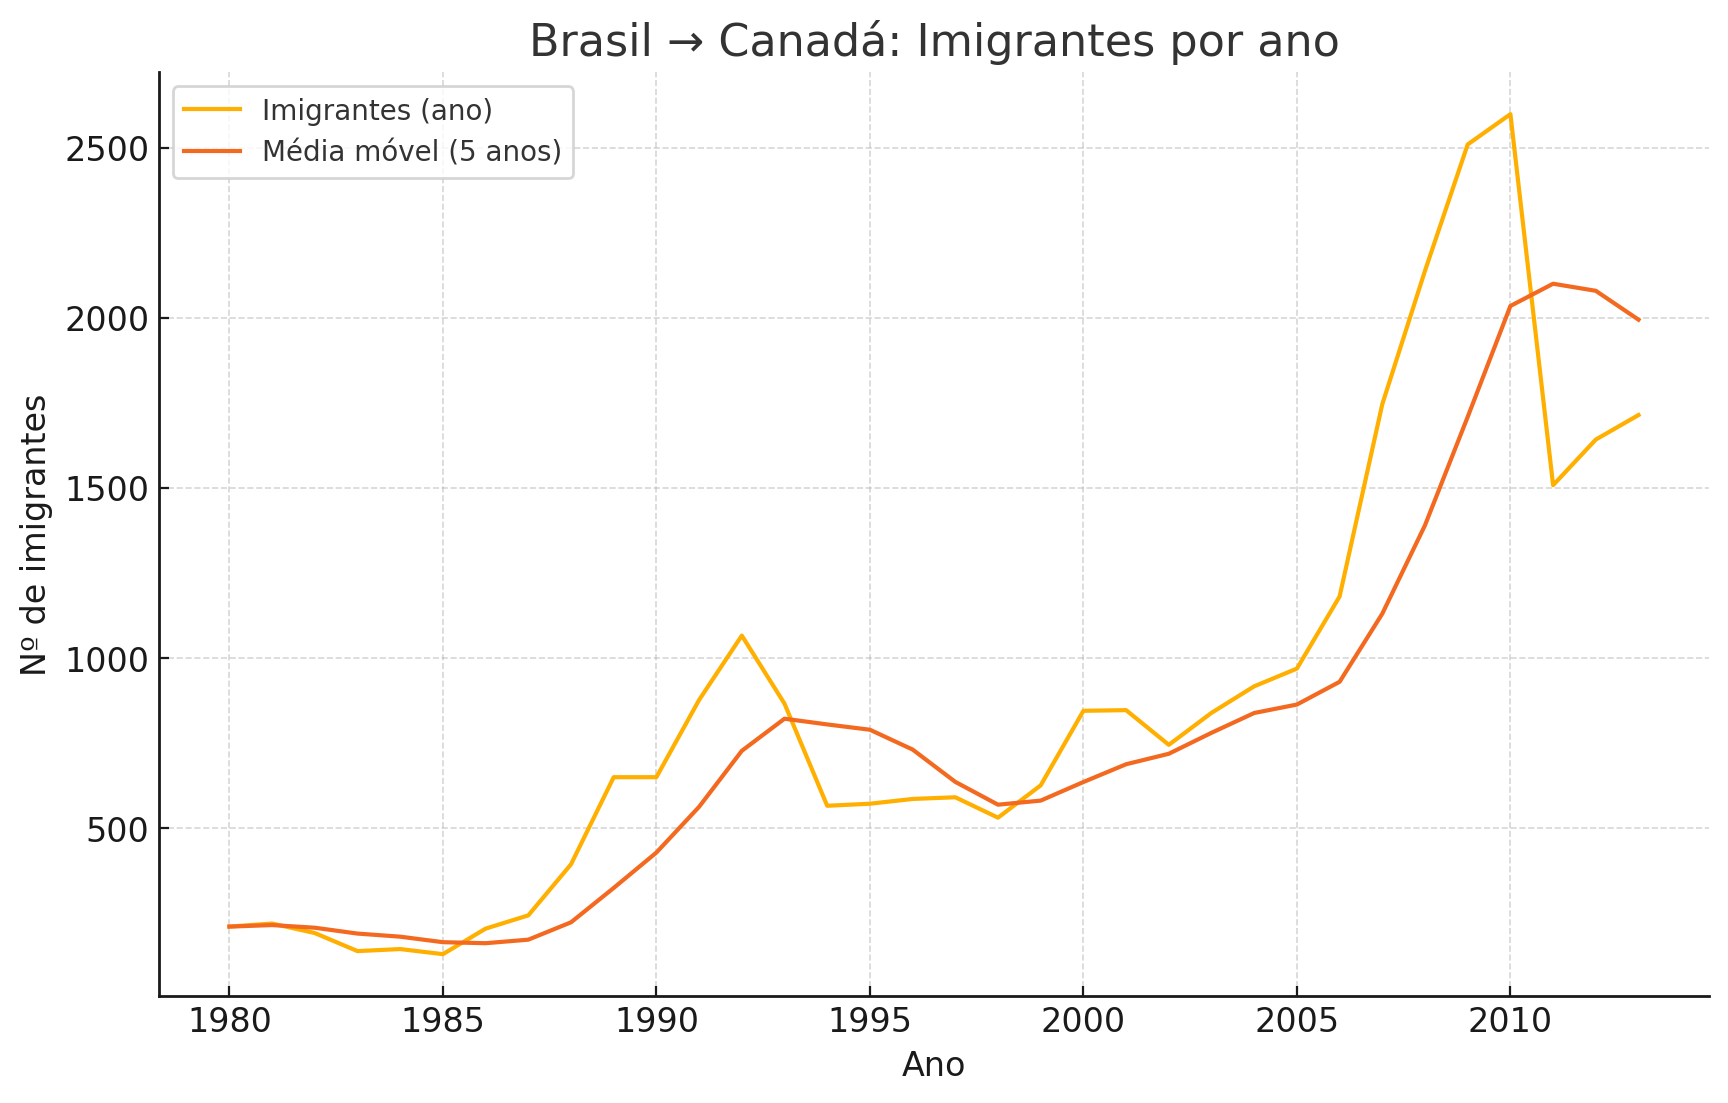

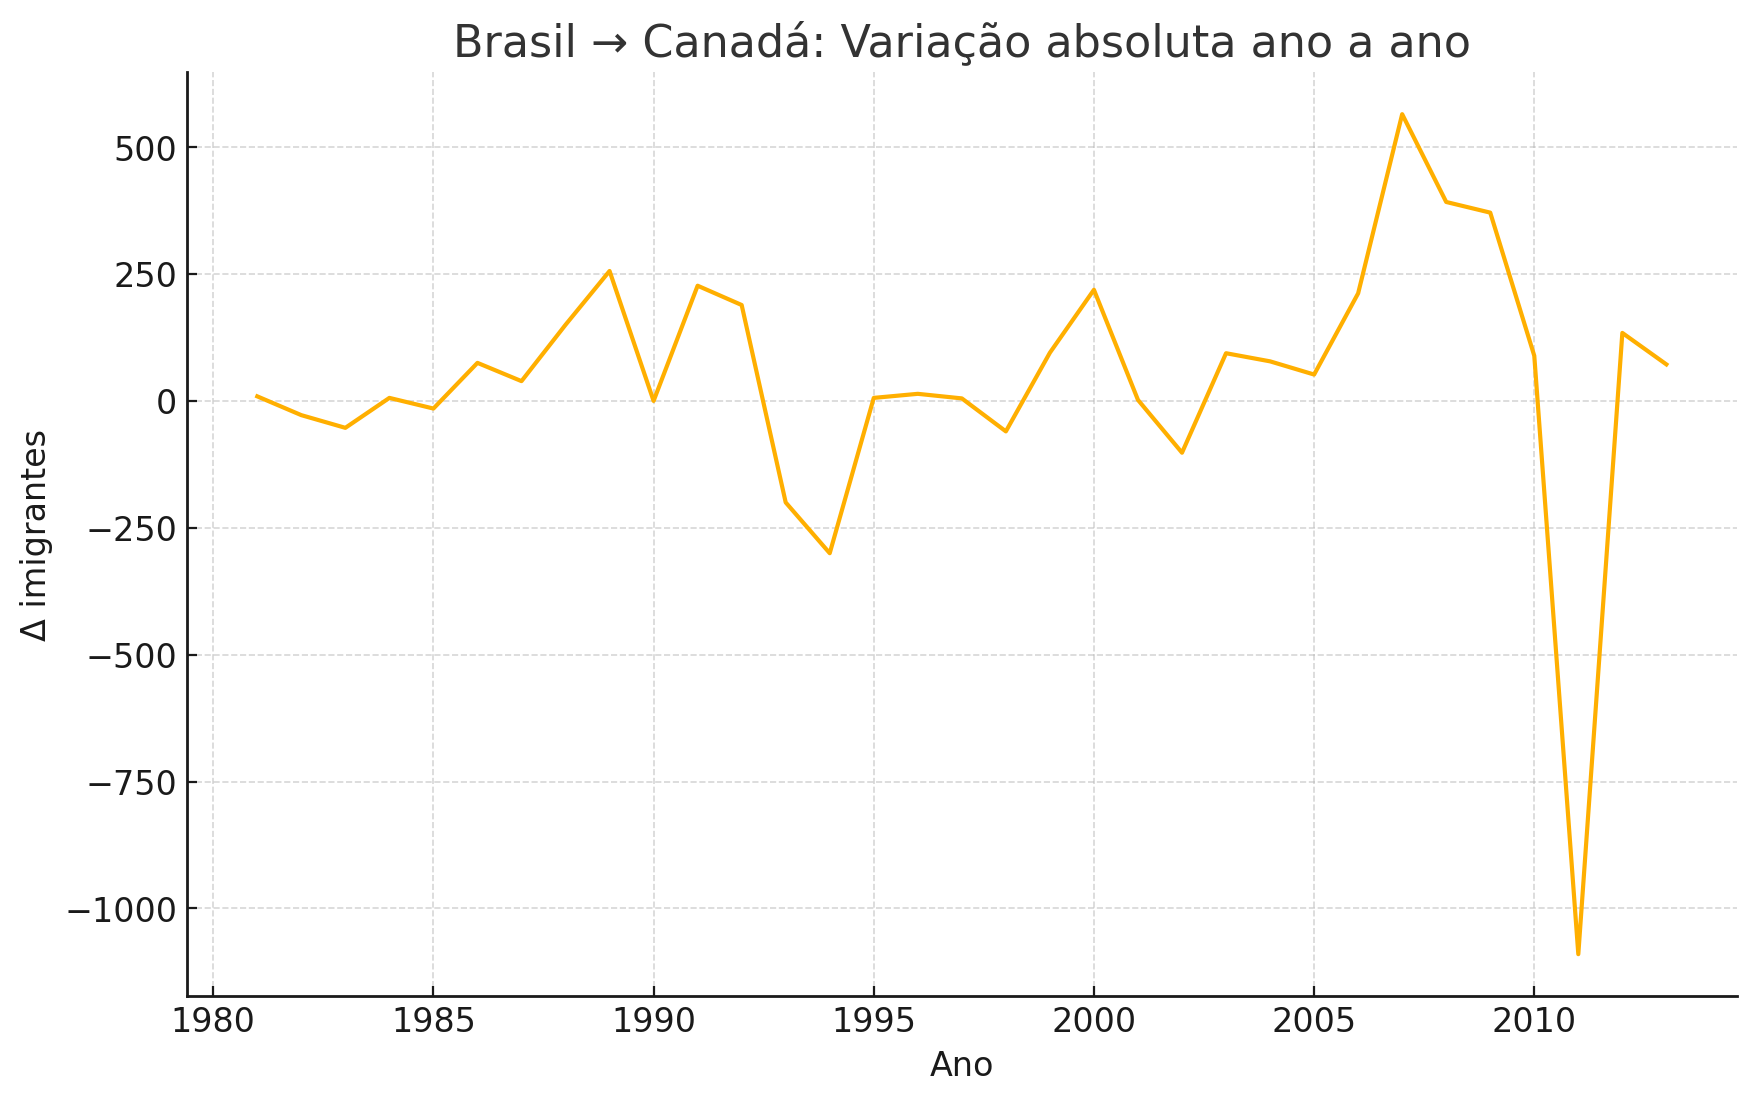

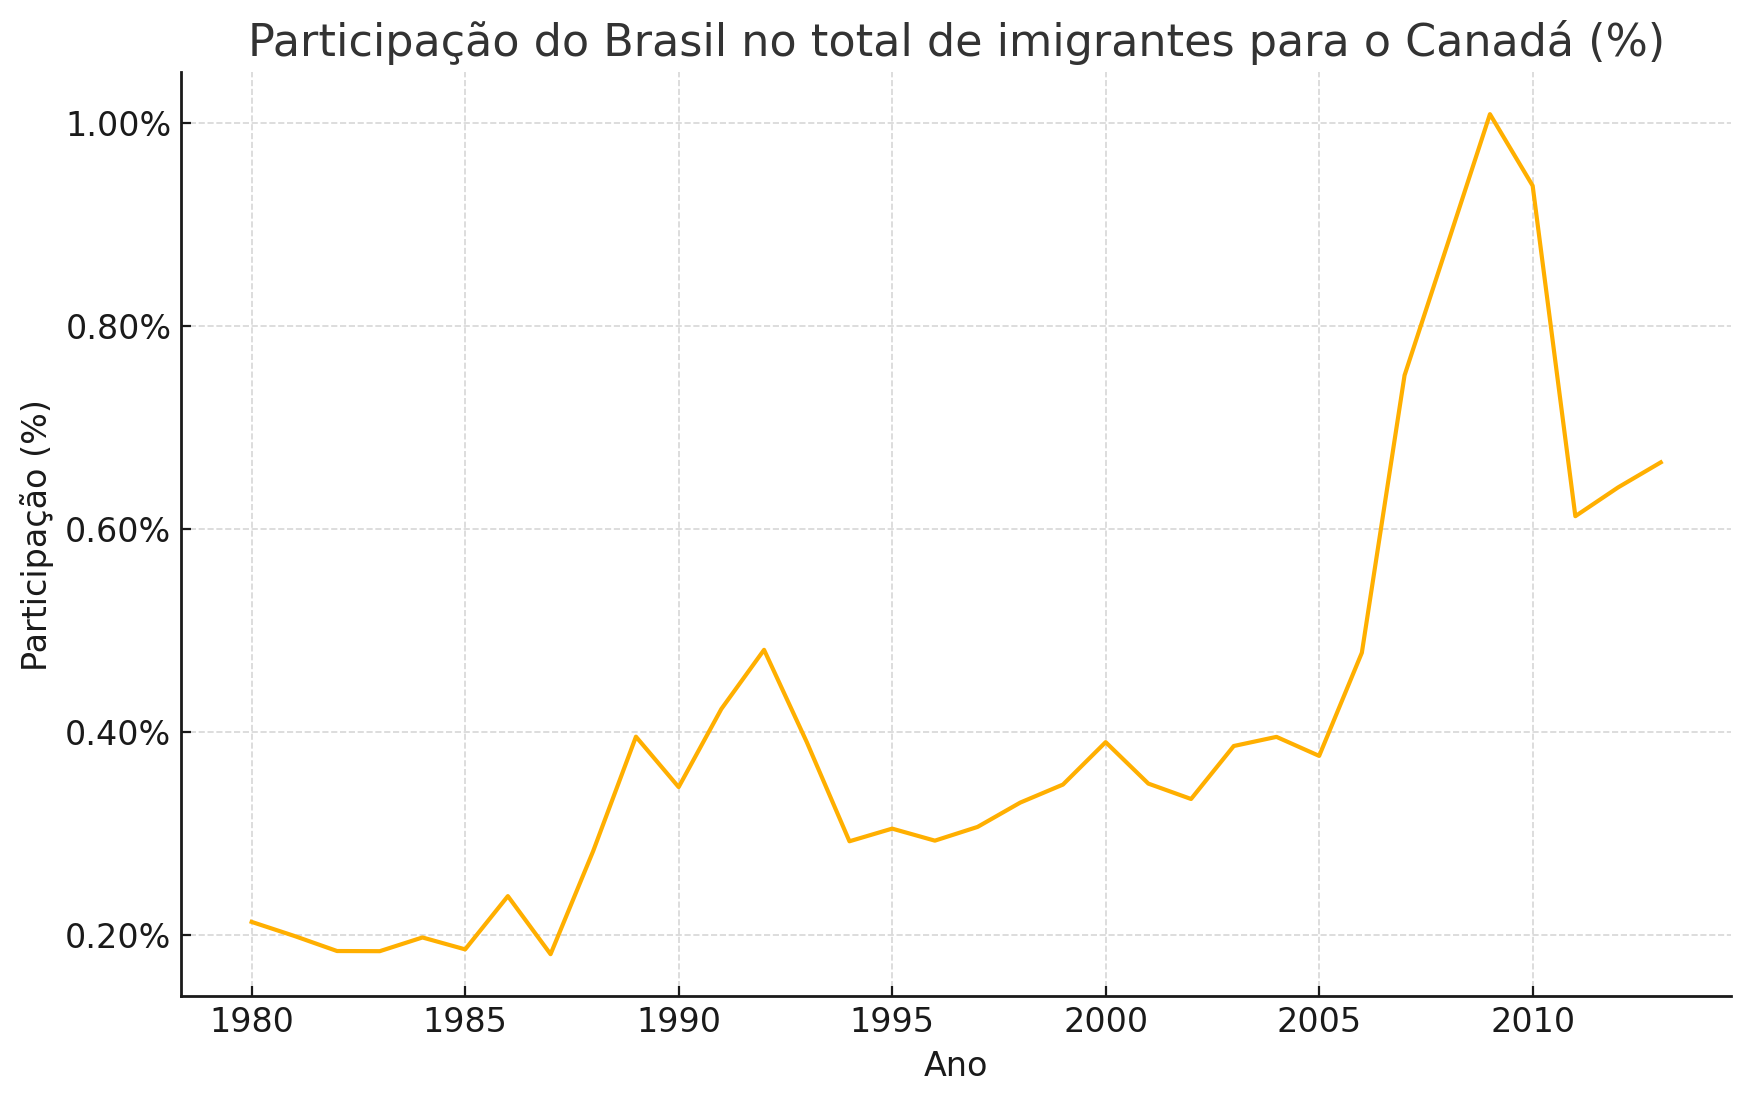

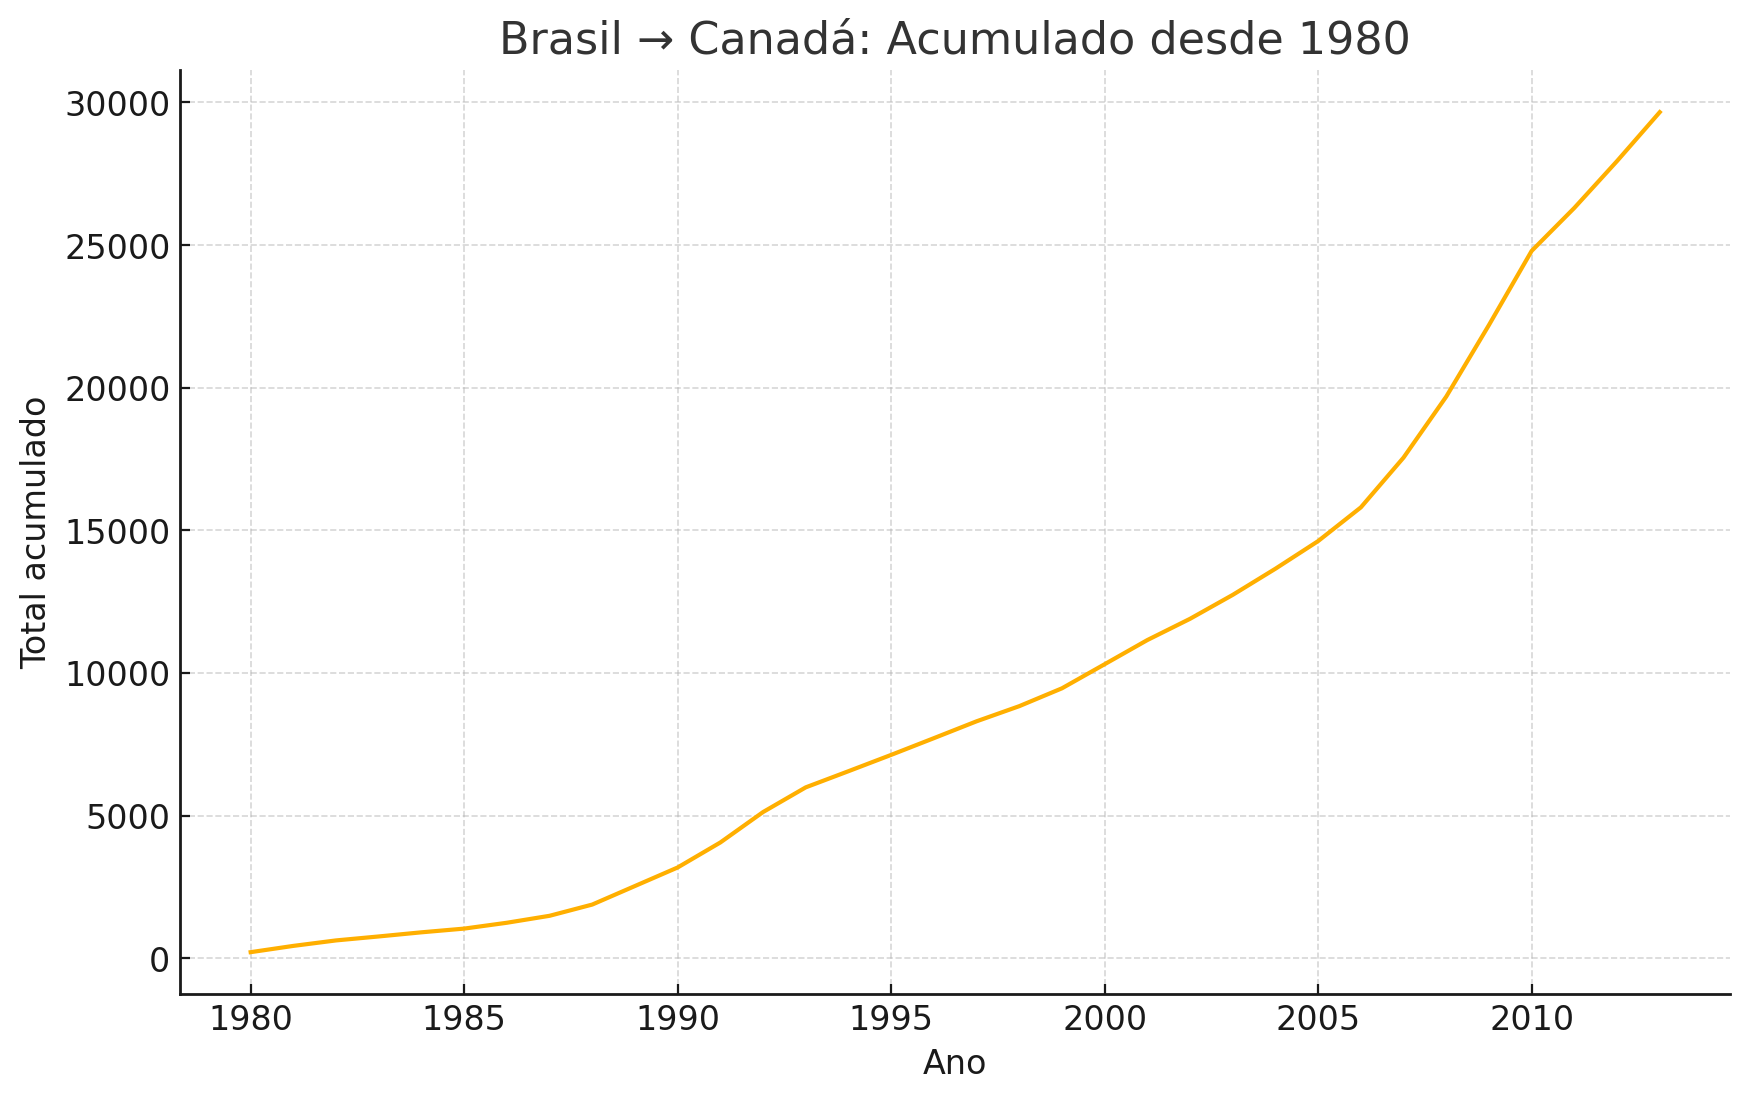

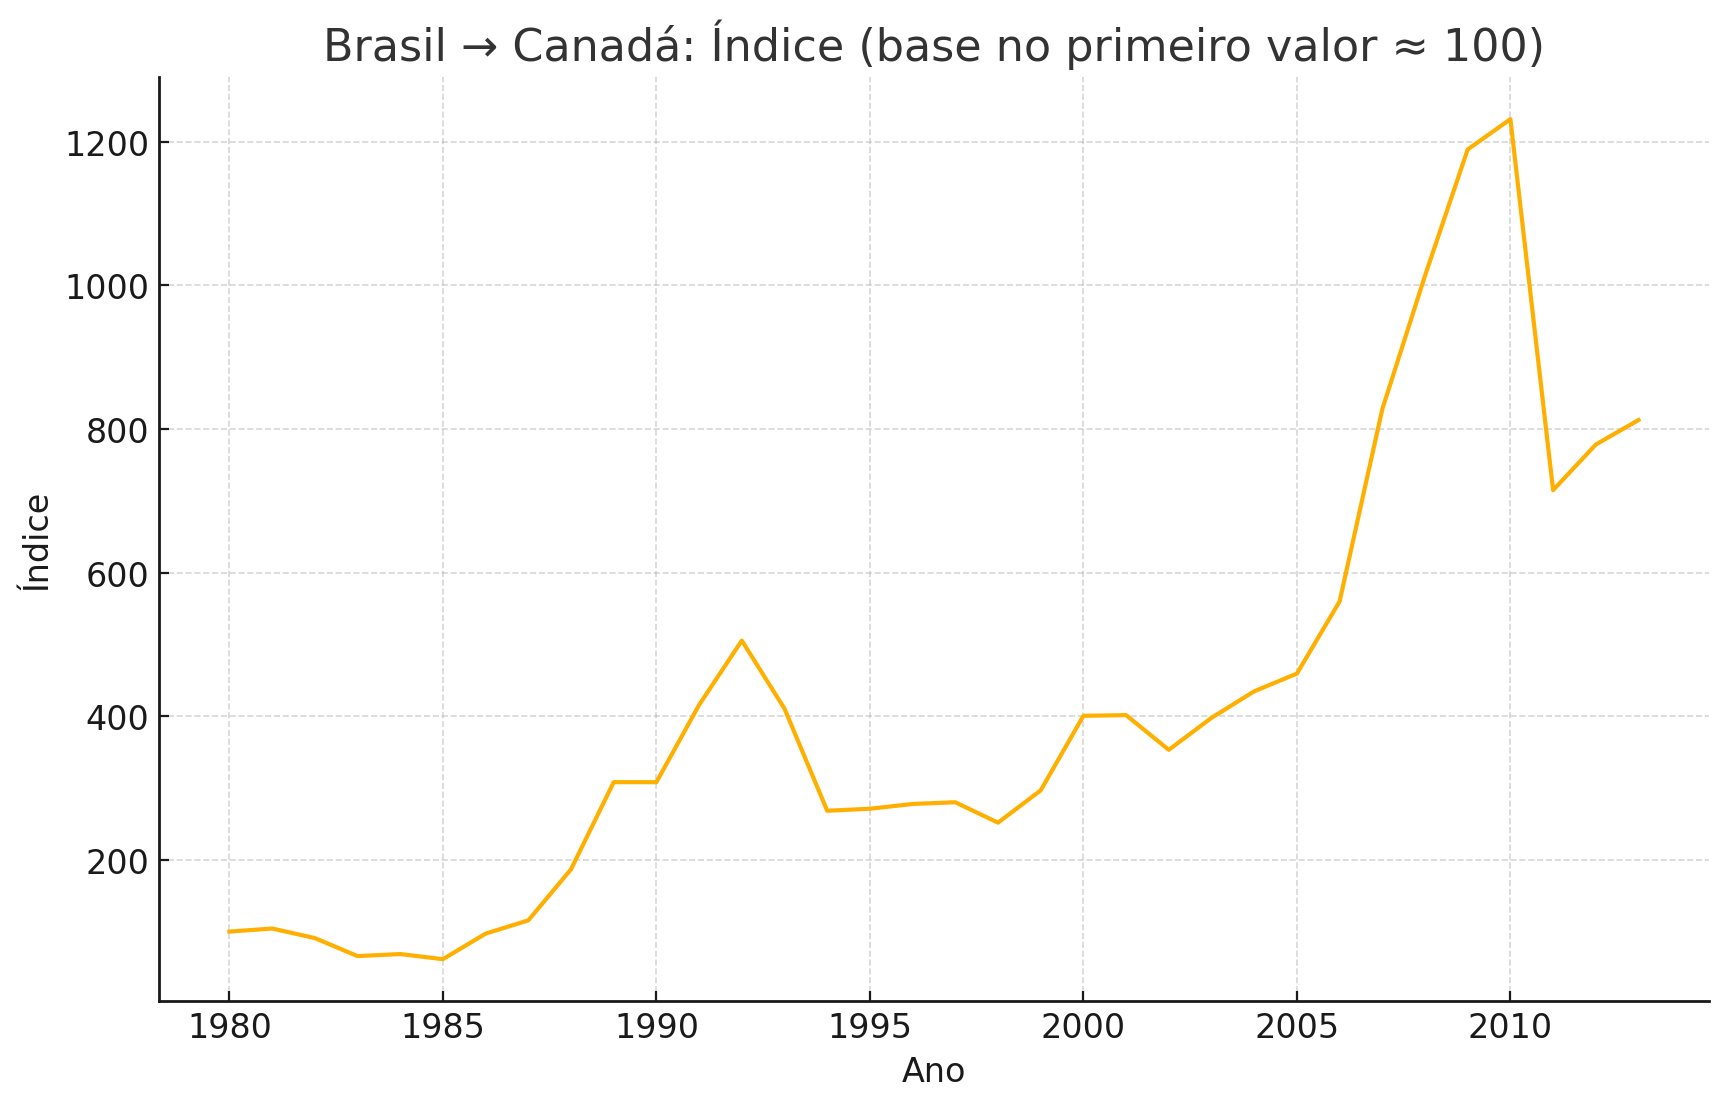

Gráficos salvos:
- exports/01_brasil_imigrantes_por_ano.png
- exports/02_brasil_yoy_abs.png
- exports/03_brasil_participacao.png
- exports/04_brasil_acumulado.png
- exports/05_brasil_indice_base100.png


In [9]:

arquivos = plot_brasil_series(brazil_df, EXPORT_DIR)
print("Gráficos salvos:")
for p in arquivos:
    print("-", p)


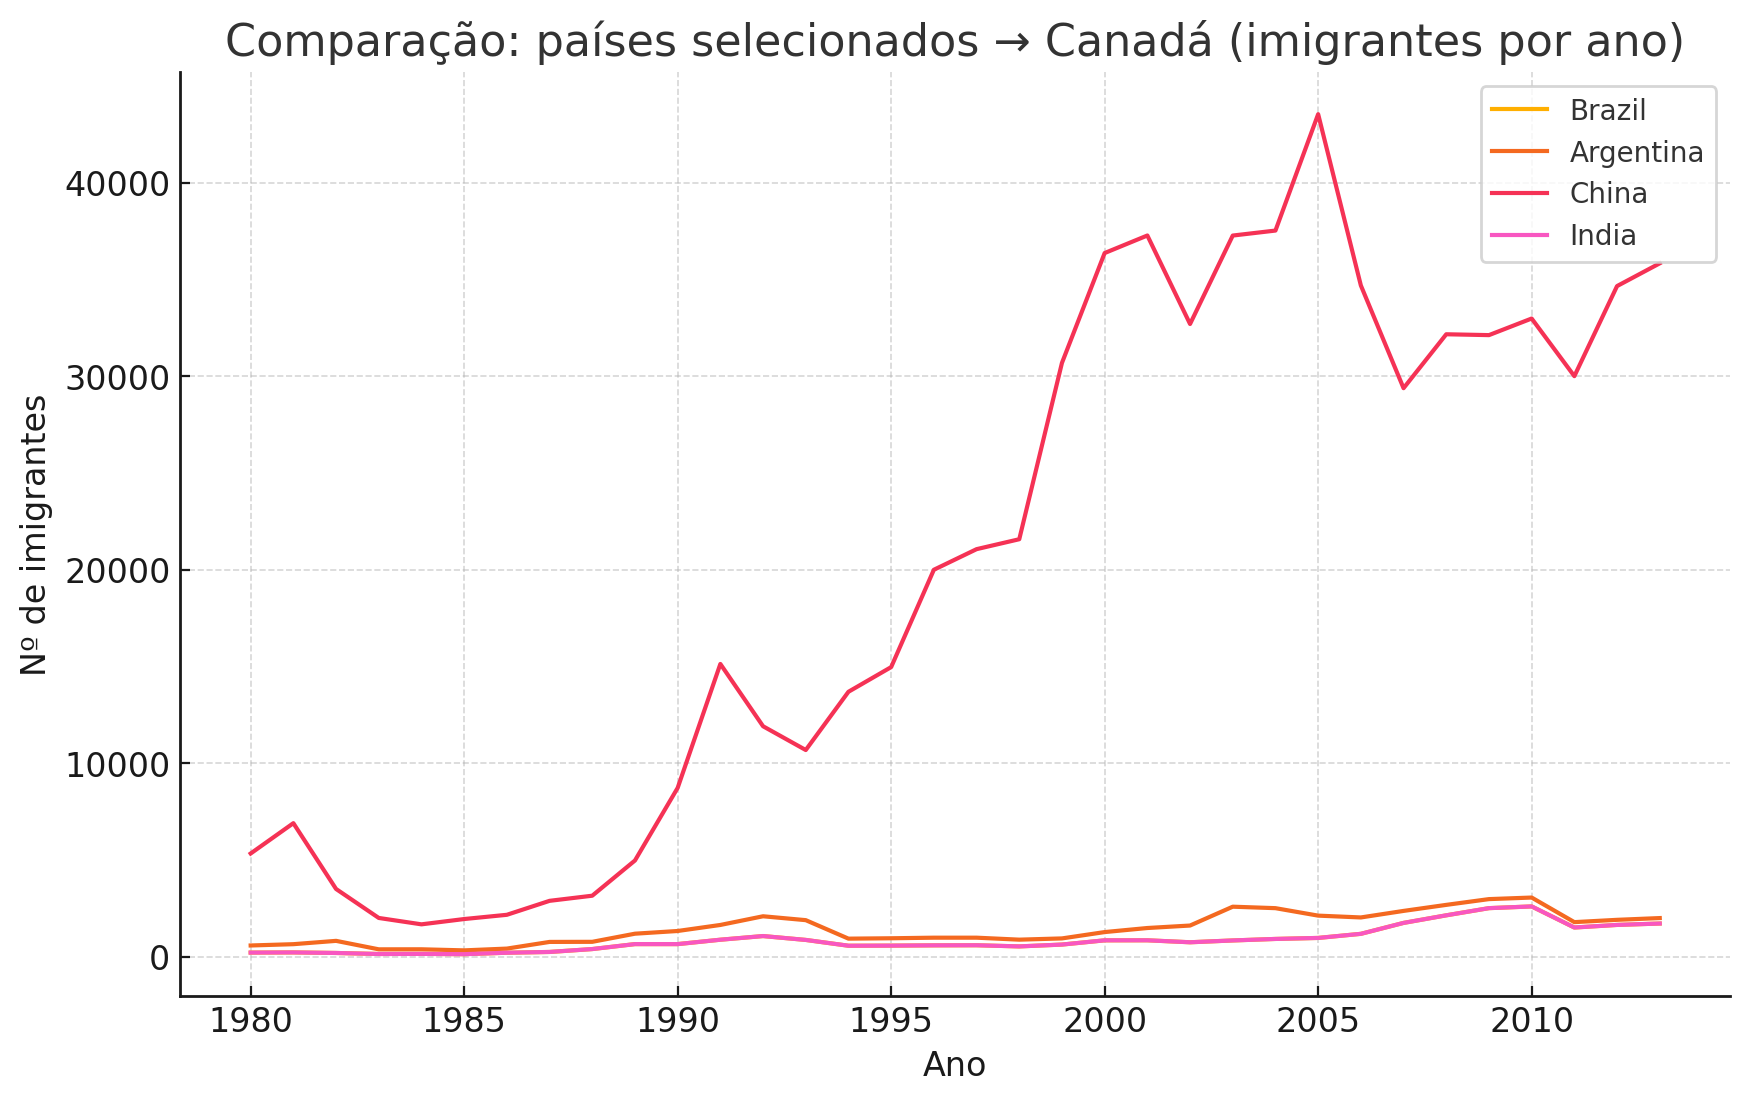

Gráfico de comparação salvo em: exports/06_comparacao_paises.png


In [10]:

p_comp = plot_comparacao(df, country_col, year_cols, PAISES_COMPARACAO, EXPORT_DIR)
print("Gráfico de comparação salvo em:", p_comp)


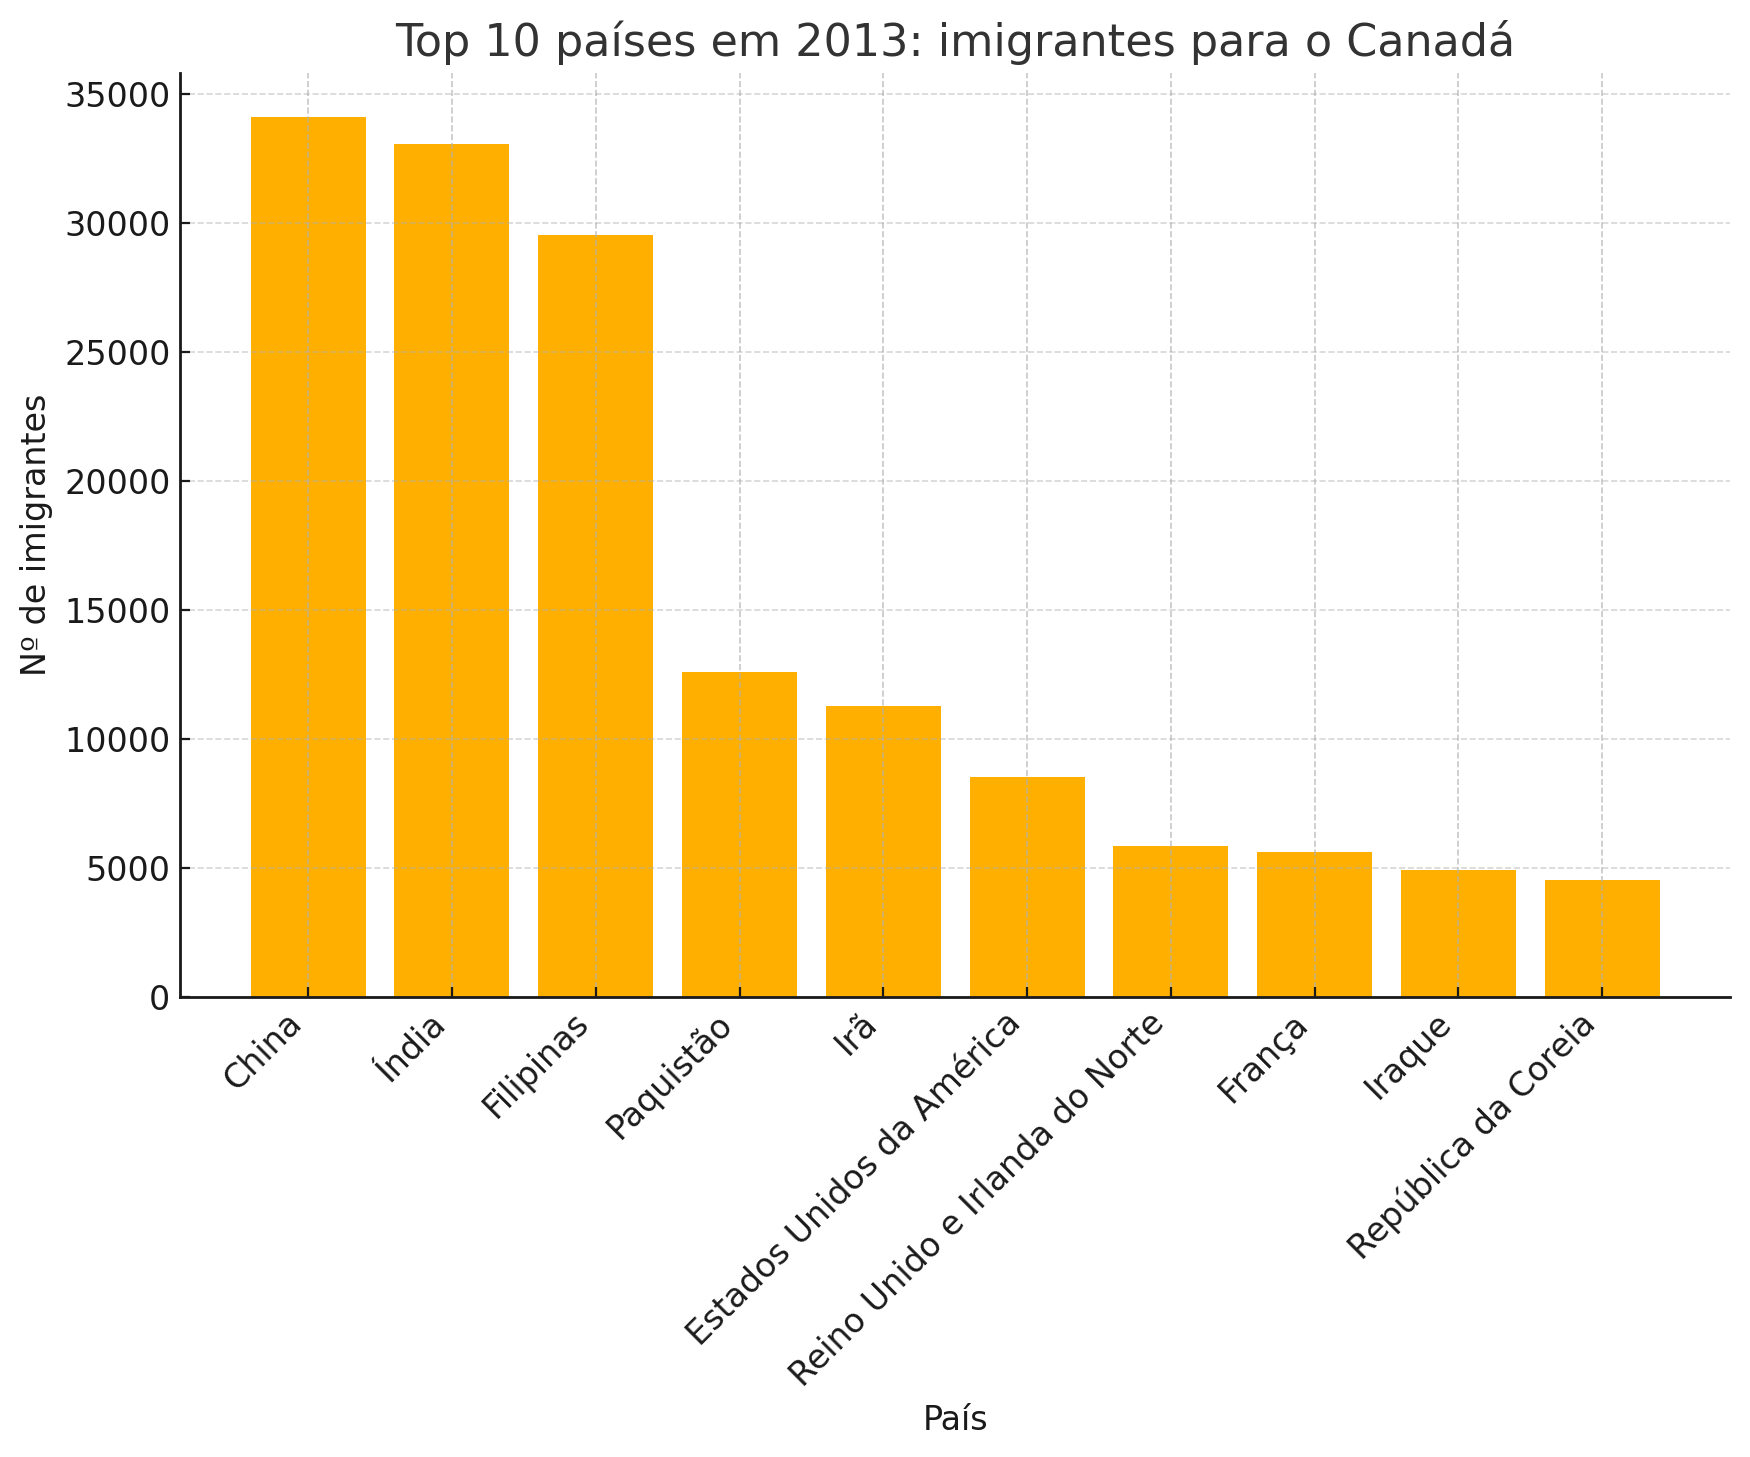

Top 10 países em 2013 salvo em: exports/07_top10_2013.png


In [11]:

ano_final = years[-1]
p_top = plot_topN_ano(df, country_col, year_cols, ano_final, 10, EXPORT_DIR)
print(f"Top 10 países em {ano_final} salvo em:", p_top)


In [12]:

first_nonzero_idx = brazil_df["Imigrantes"].to_numpy().nonzero()[0]
start_idx = int(first_nonzero_idx[0]) if len(first_nonzero_idx) > 0 else 0
start_year = int(brazil_df.loc[start_idx, "Ano"])
end_year = int(brazil_df.loc[brazil_df.index[-1], "Ano"])
start_val = float(brazil_df.loc[start_idx, "Imigrantes"])
end_val = float(brazil_df.loc[brazil_df.index[-1], "Imigrantes"])
n_years = end_year - start_year if end_year > start_year else 1
cagr = (end_val / start_val) ** (1.0 / n_years) - 1.0 if (start_val > 0 and n_years > 0) else np.nan

max_year = int(brazil_df.loc[brazil_df["Imigrantes"].idxmax(), "Ano"])
max_val = int(brazil_df["Imigrantes"].max())
min_year = int(brazil_df.loc[brazil_df["Imigrantes"].idxmin(), "Ano"])
min_val = int(brazil_df["Imigrantes"].min())

yoy_abs = brazil_df.dropna(subset=["YoY_Abs"])
if not yoy_abs.empty:
    yoy_best_year = int(yoy_abs.loc[yoy_abs["YoY_Abs"].idxmax(), "Ano"])
    yoy_best_change = int(yoy_abs["YoY_Abs"].max())
    yoy_worst_year = int(yoy_abs.loc[yoy_abs["YoY_Abs"].idxmin(), "Ano"])
    yoy_worst_change = int(yoy_abs["YoY_Abs"].min())
else:
    yoy_best_year = yoy_best_change = yoy_worst_year = yoy_worst_change = None

print(f"Ano com maior volume: {max_year} ({max_val})")
print(f"Ano com menor volume: {min_year} ({min_val})")
print(f"CAGR {start_year}–{end_year}: {cagr*100:.2f}%")
print(f"Maior alta anual: {yoy_best_change:+d} em {yoy_best_year}")
print(f"Maior queda anual: {yoy_worst_change:+d} em {yoy_worst_year}")


Ano com maior volume: 2010 (2598)
Ano com menor volume: 1985 (130)
CAGR 1980–2013: 6.55%
Maior alta anual: +565 em 2007
Maior queda anual: -1090 em 2011


---
### Próximos passos
- Trocar `PAISES_COMPARACAO` para outras combinações e reexecutar.
- Filtrar janelas temporais (ex.: pós-2005) para análises temáticas.
- Integrar indicadores econômicos/visas (dados externos) para inferir causalidade.
- Exportar relatório PDF com os gráficos e o sumário.
